In [1]:
import soccerdata as sd
from joblib import Parallel, delayed
import pandas as pd
from tqdm import tqdm
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor


[05/16/24 23:15:47] INFO     No custom team name replacements found. You can configure these in       ]8;id=862657;file://c:\Users\gfuen\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\_config.py\_config.py]8;;\:]8;id=743156;file://c:\Users\gfuen\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\_config.py#87\87]8;;\
                             C:\Users\gfuen\soccerdata\config\teamname_replacements.json.                          

                    INFO     No custom league dict found. You can configure additional leagues in    ]8;id=238232;file://c:\Users\gfuen\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\_config.py\_config.py]8;;\:]8;id=176909;file://c:\Users\gfuen\AppData\Local\Programs\Python\Python310\lib\site-packages\soccerdata\_config.py#283\283]8;;\
                             C:\Users\gfuen\soccerdata\config\league_dict.json.                                    

In [2]:
df1 = pd.read_csv("FootballData_ENG-Premier League.csv")
# df2 = pd.read_csv("FootballData_ITA-Serie A.csv")
# df3 = pd.read_csv("FootballData_ESP-La Liga.csv")
# df4 = pd.read_csv("FootballData_GER-Bundesliga.csv")
# df5 = pd.read_csv("FootballData_FRA-Ligue 1.csv")
df = pd.concat([df1])
df["Date"] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df = df.sort_values(by='Date')

In [3]:
df = df.drop(["Unnamed: 0.1","Div","Time","Referee"], axis=1)

In [4]:
# Dropearemos todas las columnas que tienen menos del 50% de los datos
porcentaje_minimo = 0.5 * len(df)
df = df.dropna(axis=1, thresh=int(porcentaje_minimo))
df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,...,IWA,WHH,WHD,WHA,VCH,VCD,VCA,LBH,LBD,LBA
4969,1993-08-14,Oldham,Ipswich,0.0,3.0,A,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4964,1993-08-14,Aston Villa,QPR,4.0,1.0,H,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4965,1993-08-14,Chelsea,Blackburn,1.0,2.0,A,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4963,1993-08-14,Arsenal,Coventry,0.0,3.0,A,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4966,1993-08-14,Liverpool,Sheffield Weds,2.0,0.0,H,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3481,2024-03-10,Liverpool,Man City,1.0,1.0,D,0.0,1.0,A,19.0,...,NaN,2.90,3.8,2.2,2.88,3.70,2.20,NaN,NaN,NaN
3478,2024-03-10,Aston Villa,Tottenham,0.0,4.0,A,0.0,0.0,D,10.0,...,NaN,2.38,4.2,2.5,2.38,3.80,2.55,NaN,NaN,NaN
3479,2024-03-10,Brighton,Nott'm Forest,1.0,0.0,H,1.0,0.0,H,10.0,...,NaN,1.75,4.0,4.2,1.75,3.75,4.20,NaN,NaN,NaN
3480,2024-03-10,West Ham,Burnley,2.0,2.0,D,0.0,2.0,A,22.0,...,NaN,1.65,4.0,4.8,1.62,3.90,5.00,NaN,NaN,NaN


In [5]:
df_ceros = df.fillna(-1)

for columna in df_ceros.columns:
    if columna not in df.select_dtypes(["object"]).keys():
        nombre_columna_indicadora = columna + '_presente'
        df[nombre_columna_indicadora] = df_ceros[columna].apply(lambda x: 1 if x != -1 else 0)
df = df.fillna(0)

In [6]:
casas = ["B365", "BW", "IW", "WH", "VC", "LB"]
features = ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH',
            'IWD', 'IWA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'LBH', 'LBD',
            'LBA','B365H_presente', 'B365D_presente',
            'B365A_presente', 'BWH_presente', 'BWD_presente', 'BWA_presente',
            'IWH_presente', 'IWD_presente', 'IWA_presente', 'WHH_presente',
            'WHD_presente', 'WHA_presente', 'VCH_presente', 'VCD_presente',
            'VCA_presente', 'LBH_presente', 'LBD_presente', 'LBA_presente']

In [8]:
def get_features(data, features):
    return pd.DataFrame(data[features]).T


def search_apuestas(i, df, last_games, features):
    team_home = df.iloc[i]["HomeTeam"]
    team_away = df.iloc[i]["AwayTeam"]
    # Para hacer la busqueda más eficiente, solo buscamos en los partidos que estos equipos juegan
    df_match_home1 = df[df["HomeTeam"] == team_home]
    df_match_home2 = df[df["AwayTeam"] == team_home]
    df_match_away1 = df[df["HomeTeam"] == team_away]
    df_match_away2 = df[df["AwayTeam"] == team_away]

    merged_df_home = pd.concat([df_match_home1, df_match_home2])
    merged_df_home.drop_duplicates(inplace=True)
    merged_df_home = merged_df_home.sort_values(by="Date", ascending=False)

    merged_df_away = pd.concat([df_match_away1, df_match_away2])
    merged_df_away.drop_duplicates(inplace=True)
    merged_df_away = merged_df_away.sort_values(by="Date", ascending=False)

    # El index 0 es el partido, por lo que iteramos desde el 1
    data_home = pd.DataFrame()
    data_away = pd.DataFrame()
    if len(merged_df_home) < last_games or len(merged_df_away)<last_games:
        return pd.DataFrame(), False

    for j in range(last_games):
        if team_home == merged_df_home.iloc[j]["HomeTeam"]:
            d = get_features(merged_df_home.iloc[j], features)
            d["played_home"] = 1
            d["played_away"] = 0
            data_home = pd.concat([data_home, d.T],axis=1)

        elif team_home == merged_df_home.iloc[j]["AwayTeam"]:
            d = get_features(merged_df_home.iloc[j], features)
            d["played_home"] = 0
            d["played_away"] = 1
            data_home = pd.concat([data_home, d.T],axis=1)
        

    for j in range(last_games):
        if team_away == merged_df_away.iloc[j]["HomeTeam"]:
            d = get_features(merged_df_away.iloc[j], features)
            d["played_home"] = 1
            d["played_away"] = 0
            data_away = pd.concat([data_away, d.T],axis=1)
        elif team_away == merged_df_away.iloc[j]["AwayTeam"]:
            d = get_features(merged_df_away.iloc[j], features)
            d["played_home"] = 0
            d["played_away"] = 1
            data_away = pd.concat([data_away, d.T],axis=1)

    data = pd.concat([data_home.T, data_away.T])

    data = data.reset_index(drop=True)

    data = data.stack().to_frame().T

    df_f = pd.DataFrame()

    for j in range(1,last_games*2):
        parte = data[j].add_suffix(f"_{j}",axis=1)
        df_f = pd.concat([df_f,parte],axis=1)

    return df_f, df.iloc[i]["FTR"]

prueba = search_apuestas(3500, df.head(3500+1), 5, features)
prueba[0]


,B365H_1,B365D_1,B365A_1,BWH_1,BWD_1,BWA_1,IWH_1,IWD_1,IWA_1,WHH_1,...,WHD_presente_9,WHA_presente_9,VCH_presente_9,VCD_presente_9,VCA_presente_9,LBH_presente_9,LBD_presente_9,LBA_presente_9,played_home_9,played_away_9
0,2.05,3.6,3.5,2.05,3.4,3.6,0.0,0.0,0.0,2.1,...,1,1,1,1,1,0,0,0,0,1


In [9]:
# Programa lineal
last_games = 15
resultados = []
for i in tqdm(range(len(df))):
    info = search_apuestas(i,df.head(i+1),last_games,features)
    resultados.append(info)

 85%|████████▌ | 10046/11752 [09:53<01:40, 16.93it/s]


KeyboardInterrupt: 

In [ ]:
X = pd.DataFrame()
X_aux  =[]
y = []
for i in tqdm(range(len(resultados))):
    X_aux.append(resultados[i][0])
    if resultados[i][1]:
        y.append(resultados[i][1])
X = pd.concat(X_aux)
X = X.astype(float)
y = np.array(y)
y = pd.get_dummies(y,dtype=int)

100%|██████████| 11752/11752 [00:00<00:00, 1679665.39it/s]


In [ ]:
df_WS = pd.read_csv("ENG-Premier LeagueWhoScoredTeamNumMatches15Spatial12x8TimeDiv90.csv")

df_WS = df_WS.drop(["Unnamed: 0", "Unnamed: 0.1"], axis =1)

In [49]:
df_WS.head()

,Team,Date,Goals,Number_matches,game_id,Pass_Successful_bin_0_time_0-90,Pass_Unsuccessful_bin_0_time_0-90,Pass_Successful_bin_1_time_0-90,Pass_Unsuccessful_bin_1_time_0-90,Pass_Successful_bin_2_time_0-90,...,Error_Successful_bin_91_time_0-90,Error_Unsuccessful_bin_91_time_0-90,Error_Successful_bin_92_time_0-90,Error_Unsuccessful_bin_92_time_0-90,Error_Successful_bin_93_time_0-90,Error_Unsuccessful_bin_93_time_0-90,Error_Successful_bin_94_time_0-90,Error_Unsuccessful_bin_94_time_0-90,Error_Successful_bin_95_time_0-90,Error_Unsuccessful_bin_95_time_0-90
0,West Ham,2010-08-14,0,0,410988,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aston Villa,2010-08-14,3,0,410988,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Everton,2010-08-14,0,0,410989,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Blackburn,2010-08-14,1,0,410989,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bolton,2010-08-14,0,0,410991,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
ids = df_WS.game_id.unique()


In [54]:
df_WS[df_WS.game_id == ids[20000]]

,Team,Date,Goals,Number_matches,game_id,Pass_Successful_bin_0_time_0-90,Pass_Unsuccessful_bin_0_time_0-90,Pass_Successful_bin_1_time_0-90,Pass_Unsuccessful_bin_1_time_0-90,Pass_Successful_bin_2_time_0-90,...,Error_Successful_bin_91_time_0-90,Error_Unsuccessful_bin_91_time_0-90,Error_Successful_bin_92_time_0-90,Error_Unsuccessful_bin_92_time_0-90,Error_Successful_bin_93_time_0-90,Error_Unsuccessful_bin_93_time_0-90,Error_Successful_bin_94_time_0-90,Error_Unsuccessful_bin_94_time_0-90,Error_Successful_bin_95_time_0-90,Error_Unsuccessful_bin_95_time_0-90
40000,Cagliari,2015-04-29,0,15,866130,2.0,7.0,16.0,12.0,33.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40001,Chievo,2015-04-29,1,15,866130,15.0,13.0,20.0,9.0,27.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
aux = df_WS[df_WS.game_id == ids[10]]
goalsDiff = aux.iloc[0]["Goals"] - aux.iloc[1]["Goals"]
aux

,Team,Date,Goals,Number_matches,game_id,Pass_Successful_bin_0_time_0-90,Pass_Unsuccessful_bin_0_time_0-90,Pass_Successful_bin_1_time_0-90,Pass_Unsuccessful_bin_1_time_0-90,Pass_Successful_bin_2_time_0-90,...,Error_Successful_bin_91_time_0-90,Error_Unsuccessful_bin_91_time_0-90,Error_Successful_bin_92_time_0-90,Error_Unsuccessful_bin_92_time_0-90,Error_Successful_bin_93_time_0-90,Error_Unsuccessful_bin_93_time_0-90,Error_Successful_bin_94_time_0-90,Error_Unsuccessful_bin_94_time_0-90,Error_Successful_bin_95_time_0-90,Error_Unsuccessful_bin_95_time_0-90
20,Blackpool,2010-08-21,0,1,411016,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,Arsenal,2010-08-21,6,1,411016,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
ids = df_WS.game_id.unique()
resultados = []
y = []
for i in  tqdm(range(len(ids))):
    aux = df_WS[df_WS.game_id == ids[i]]
    if aux["Number_matches"].iloc[0] == 15 and aux["Number_matches"].iloc[1] == 15:
        goalsDiff = aux.iloc[0]["Goals"] - aux.iloc[1]["Goals"]
        
        # One Hot
        if goalsDiff > 0:
            y.append([1, 0, 0]) # Gana team 1
        if goalsDiff < 0:
            y.append([0, 0, 1]) # Gana team 2
        if goalsDiff == 0:
            y.append([0, 1, 0]) # Empate
            
        # Sparse
        # if goalsDiff > 0:
        #     y.append(0) # Gana team 1
        # if goalsDiff < 0:
        #     y.append(1) # Gana team 2
        # if goalsDiff == 0:
        #     y.append(2) # Empate


        aux = aux.drop(["Date", "game_id", "Goals", "Team"], axis = 1)

        resultados.append(pd.DataFrame(pd.concat([aux.iloc[0].add_prefix("Team1_"), aux.iloc[1].add_prefix("Team2_")])).T)

X = pd.concat(resultados)
y = np.array(y)


100%|██████████| 22968/22968 [03:07<00:00, 122.65it/s]


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.2)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train)

X_train_norm = min_max_scaler.transform(X_train)   
X_test_norm  = min_max_scaler.transform(X_test)    
# X_val_norm  = min_max_scaler.transform(X_val_clean)    

In [18]:
# X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.2)
# # X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

# sclean       = clean(X_train)      # indices of selected features
# X_train_clean = X_train[:,sclean]   # new training
# X_test_clean  = X_test[:,sclean]    # new testing
# # X_val_clean  = X_val[:,sclean]    # new testing

# min_max_scaler = MinMaxScaler()
# min_max_scaler.fit(X_train_clean)

# X_train_norm = min_max_scaler.transform(X_train_clean)   
# X_test_norm  = min_max_scaler.transform(X_test_clean)    
# # X_val_norm  = min_max_scaler.transform(X_val_clean)    

In [58]:
X_train_norm.shape

(16840, 9986)

In [ ]:
# pca = PCA(n_components=0.98)
# X_ = pca.fit_transform(X)
# min_max_scaler = MinMaxScaler()
# X_ = min_max_scaler.fit_transform(X_)

In [60]:
import tensorflow as tf
from tensorflow.keras import layers
from keras.callbacks import ReduceLROnPlateau

batch_size = 256
epoch = 100

# Define el modelo
# Construir el modelo
# Crear el modelo
model = tf.keras.Sequential([
    # layers.Dense(256, input_shape=(X_train_norm.shape[1],), activation='relu'),
    # layers.Dense(128, activation='relu'),
    # layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])
# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  
              metrics=['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=10,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.0)

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

# # Entrenamos el modelo
history = model.fit(X_train_norm, y_train, verbose=1, epochs=epoch, batch_size=batch_size, callbacks=[learning_rate_reduction],
                    validation_data=(X_test_norm, y_test))

Epoch 1/100
66/66 [==============================] - 1s 9ms/step - loss: 1.0464 - accuracy: 0.4638 - val_loss: 1.0345 - val_accuracy: 0.4767 - lr: 0.0010
Epoch 2/100
66/66 [==============================] - 0s 5ms/step - loss: 1.0011 - accuracy: 0.5087 - val_loss: 1.0141 - val_accuracy: 0.4886 - lr: 0.0010
Epoch 3/100
66/66 [==============================] - 0s 5ms/step - loss: 0.9848 - accuracy: 0.5151 - val_loss: 1.0187 - val_accuracy: 0.4869 - lr: 0.0010
Epoch 4/100
66/66 [==============================] - 0s 4ms/step - loss: 0.9678 - accuracy: 0.5303 - val_loss: 1.0206 - val_accuracy: 0.4886 - lr: 0.0010
Epoch 5/100
66/66 [==============================] - 0s 4ms/step - loss: 0.9528 - accuracy: 0.5442 - val_loss: 1.0268 - val_accuracy: 0.4876 - lr: 0.0010
Epoch 6/100
66/66 [==============================] - 0s 4ms/step - loss: 0.9370 - accuracy: 0.5559 - val_loss: 1.0270 - val_accuracy: 0.4824 - lr: 0.0010
Epoch 7/100
66/66 [==============================] - 0s 4ms/step - loss: 0.9

KeyboardInterrupt: 

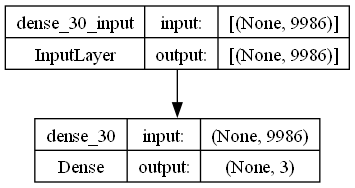

In [61]:
from keras.utils import plot_model

# Guardar el diagrama en un archivo
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [62]:
from sklearn.metrics import classification_report, confusion_matrix

# Predicciones en el conjunto de prueba
y_pred = model.predict(X_test_norm).argmax(axis=1)

# # # Métricas
print("Classification Report:")
print(classification_report(y_test.argmax(axis=1), y_pred))


132/132 [==============================] - 0s 898us/step
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.61      0.54      1604
           1       0.29      0.16      0.21      1053
           2       0.49      0.51      0.50      1553

    accuracy                           0.46      4210
   macro avg       0.42      0.43      0.42      4210
weighted avg       0.44      0.46      0.44      4210



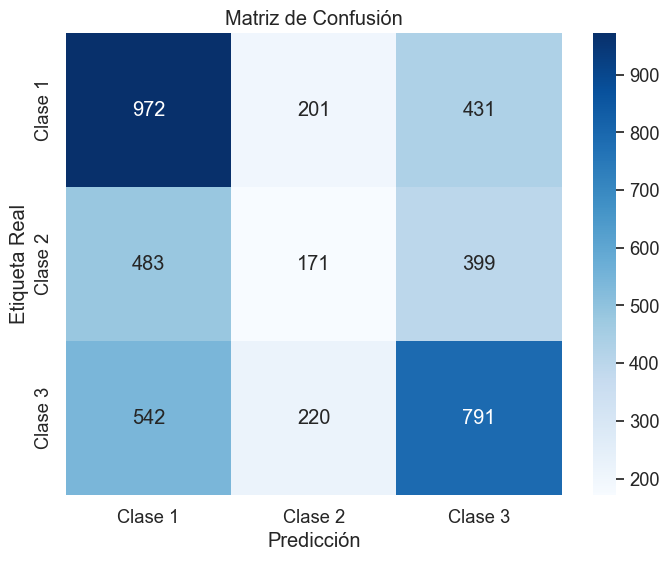

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred)

# Etiquetas de clase
class_labels = ["Clase 1", "Clase 2", "Clase 3"]

# Crear figura
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) # Ajustar el tamaño de la fuente para una mejor legibilidad
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

# Añadir etiquetas
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')

# Mostrar la matriz de confusión
plt.show()

In [71]:
import numpy as np
import pandas as pd
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from sklearn.model_selection import train_test_split


# Convertir DataFrame de pandas a matriz NumPy
X_array = X.values
y_array = y.argmax(axis=1)

# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size=0.3, random_state=42)

# Crear y entrenar el modelo TabNet
clf = TabNetClassifier()
clf.fit(X_train, y_train, eval_set=[(X_test, y_test)], max_epochs = 200, patience= 50,batch_size = 256)

# Evaluar el modelo
test_predictions = clf.predict(X_test)
# Puedes calcular las métricas de rendimiento aquí

c:\Users\gfuen\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
Exception ignored in: <function AtomicFunction.__del__ at 0x0000016264959CF0>
Traceback (most recent call last):
  File "c:\Users\gfuen\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\eager\polymorphic_function\atomic_function.py", line 226, in __del__
    self._bound_context.remove_function(self.name)
KeyboardInterrupt: 


epoch 0  | loss: 1.12514 | val_0_accuracy: 0.41172 |  0:00:05s


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Predicciones en el conjunto de prueba
y_pred = clf.predict(X_test)

# Métricas
print("Classification Report:")
print(classification_report(y_test, y_pred))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Etiquetas de clase
class_labels = ["Clase 1", "Clase 2", "Clase 3"]

# Crear figura
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) # Ajustar el tamaño de la fuente para una mejor legibilidad
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

# Añadir etiquetas
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión')

# Mostrar la matriz de confusión
plt.show()

In [22]:
# Importar las bibliotecas necesarias
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo de regresión logística
model = LogisticRegression()
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular la precisión del modelo
accuracy = np.mean(y_pred == y_test)
print("Precisión del modelo:", accuracy)

Precisión del modelo: 0.48759251197213754
